**Brain Tumor Segmentation BRATS2021**

# Upload data files first
# Change runtime to TPU or GPU

# **1. Importing Required Packages**

In [ ]:
###Libraries and imports
import numpy as np
import math
import random
import os
import shutil
import gzip
import glob
import gc
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import tarfile
import PIL
import scipy.misc
import skimage
import nibabel as nib

from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from keras import backend as K
from sklearn.model_selection import train_test_split
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from skimage.io import imread
from scipy import ndimage as ndi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from glob import glob

from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers

DEVICE = "GPU"



 # **2. Connecting to TPU or CPU and GPU incase TPU not available**

In [ ]:

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


# **Attention Based Functions**

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
!pip3 install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **3. Defining our Unet model and compiling it with adam optimizer and learning rate 0.01 And also definng evaluation matrices**

In [ ]:
from keras_visualizer import visualizer 

In [ ]:
# def Convolution(input_tensor,filters):
#     x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x) 
#     return x

# def model(input_shape):
    
#     inputs = Input((input_shape))
    
#     conv_1 = Convolution(inputs,32)
#     maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
#     conv_2 = Convolution(maxp_1,64)
#     maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
#     conv_3 = Convolution(maxp_2,128)
#     maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
#     conv_4 = Convolution(maxp_3,256)
#     maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
#     conv_5 = Convolution(maxp_4,512)
#     upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
#     conv_6 = Convolution(upsample_6,256)
#     upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
#     upsample_7 = concatenate([upsample_7, conv_3])
    
#     conv_7 = Convolution(upsample_7,128)
#     upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
#     conv_8 = Convolution(upsample_8,64)
#     upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
#     upsample_9 = concatenate([upsample_9, conv_1])
    
#     conv_9 = Convolution(upsample_9,32)
#     outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
#     model = Model(inputs=[inputs], outputs=[outputs]) 
    
#     return model

# ### Simple Unet
# def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
#     conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     conv = layers.Activation("relu")(conv)

#     conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
#     if batch_norm is True:
#         conv = layers.BatchNormalization(axis=3)(conv)
#     conv = layers.Activation("relu")(conv)
    
#     if dropout > 0:
#         conv = layers.Dropout(dropout)(conv)

#     return conv

# def model(input_shape):

#     # network structure
#     FILTER_NUM = 64 # number of filters for the first layer
#     FILTER_SIZE = 3 # size of the convolutional filter
#     UP_SAMP_SIZE = 2 # size of upsampling filters
#     NUM_CLASSES=1
#     dropout_rate=0.0
#     batch_norm=True

#     inputs = layers.Input(input_shape, dtype=tf.float32)

#     # Downsampling layers
#     # DownRes 1, convolution + pooling
#     conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
#     pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
#     # DownRes 2
#     conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
#     pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
#     # DownRes 3
#     conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
#     pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
#     # DownRes 4
#     conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
#     pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
#     # DownRes 5, convolution only
#     conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

#     # Upsampling layers
   
#     up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
#     up_16 = layers.concatenate([up_16, conv_16], axis=3)
#     up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
#     # UpRes 7
    
#     up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
#     up_32 = layers.concatenate([up_32, conv_32], axis=3)
#     up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
#     # UpRes 8
    
#     up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
#     up_64 = layers.concatenate([up_64, conv_64], axis=3)
#     up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
#     # UpRes 9
   
#     up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
#     up_128 = layers.concatenate([up_128, conv_128], axis=3)
#     up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

#     # 1*1 convolutional layers
   
#     conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
#     conv_final = layers.BatchNormalization(axis=3)(conv_final)
#     conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

#     # Model 
#     model = models.Model(inputs, conv_final, name="UNet")
# #     print(model.summary())
#     return model

### Residual Attenton Based UNET
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path
def model(input_shape):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    NUM_CLASSES=1 
    dropout_rate=0.0 
    batch_norm=True
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    print(model.summary())
    #visualizer(model, format='png', view=True)
    return model
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

#print("-- Compiling the model with: ", DEVICE)
input_size = 240
if DEVICE=='TPU':
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    with tpu_strategy.scope():
        model = model(input_shape = (input_size, input_size, 1))
        Adam=optimizers.Adam(lr=0.001)
        model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])        
else:   
    model = model(input_shape = (input_size, input_size, 1))
    Adam=optimizers.Adam(lr=0.001)
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **4. This command will delete all directories**

In [ ]:
!rm -Rf ./post_process_data
!rm -Rf ./data
!rm -Rf ./final_models

# **5. Creating data directory and extracting our data their and visualizing it.**

In [ ]:
#
#tar = tarfile.open("BraTS2021_00495.tar")
#tar.extractall("./data")
#tar.close()

#tar = tarfile.open("BraTS2021_00621.tar")
#tar.extractall("./data", )
#tar.close()

In [ ]:
!mkdir data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/ProjectBrain"


tar = tarfile.open("/content/drive/MyDrive/ProjectBrain/BraTS2021_Training_Data.tar")
tar.extractall("./data")
tar.close()

tar = tarfile.open("/content/drive/MyDrive/ProjectBrain/BraTS2021_00495.tar")
tar.extractall("./data")
tar.close()

BraTs2020_2.h5	     BraTS2021_00621.tar
BraTS2021_00495.tar  BraTS2021_Training_Data.tar


In [ ]:
tar = tarfile.open("/content/drive/MyDrive/ProjectBrain/BraTS2021_00621.tar")
tar.extractall("./data", )
tar.close()

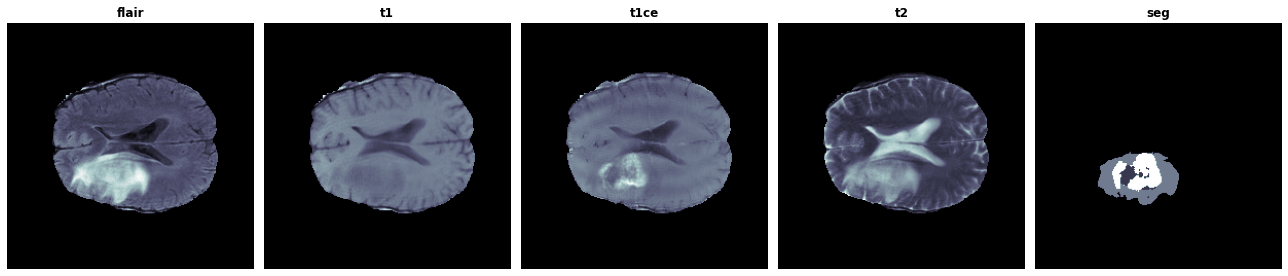

In [ ]:
#!mkdir data

#tar = tarfile.open("BraTS2021_Training_Data.tar")
#tar.extractall("./data")
#tar.close()

#tar = tarfile.open("BraTS2021_00495.tar")
#tar.extractall("./data")
#tar.close()

#tar = tarfile.open("BraTS2021_00621.tar")
#tar.extractall("./data", )
#tar.close()

img_id = "01281"
plt.figure(figsize=(18, 5))
for i, nii in enumerate([f'./data/BraTS2021_{img_id}/BraTS2021_{img_id}_{s_type}.nii.gz' for s_type in ["flair", "t1", "t1ce", "t2", "seg"]]):
    plt.subplot(1,5,i+1)
    image=nib.load(nii).get_fdata()
    plt.title(nii.rsplit("_", 1)[1].split(".", 1)[0], fontweight="bold")
    plt.axis(False)
    plt.imshow(image[:, :, 80], cmap="bone")
plt.tight_layout()    
plt.show()

# **6. Listing items in /data/BraTS2021_00000/ folder**

In [ ]:
!dir "data/BraTS2021_00000/"

BraTS2021_00000_flair.nii.gz  BraTS2021_00000_t1.nii.gz
BraTS2021_00000_seg.nii.gz    BraTS2021_00000_t2.nii.gz
BraTS2021_00000_t1ce.nii.gz


# **7. Arranging Dataset in an order**

Firstly creating three paths one for model and one for data after it is sorted in an order. And one path of whole data which is used source and post process data as destination in shuttil.move command in python.

In [ ]:
import glob

# Declaring paths
Path_brats= './data/BraTS2021_'
post_data='./post_process_data'
final_models='./final_models'

#Creating directories
os.mkdir(post_data)
os.mkdir(final_models)

# Creating a text file which will contain list of all data set numbers in sorted order like 0001 etc. 
# This will be used in ordering data
!ls ./data/ | awk -F'[_]' '{print $2}' > test.txt
post_data='./post_process_data/'
with open('./test.txt') as f:
    for linea in f:
        path_dest=post_data+linea
        path_dest=path_dest.replace('\n','')
        if os.path.isdir(path_dest) != True:
            os.mkdir(path_dest)
        create_path_brats=Path_brats+linea+'/*'
        for name in sorted(glob.glob(create_path_brats.replace('\n',''))):        
            shutil.move(name,path_dest)

# **8. Concatenating or preparing dataset and defining train-test split and epochs in model**

In [ ]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output
    
def launch_model(Input_Data,code,model):
    
    InData= Data_Concatenate(Input_Data)
    AIO= concatenate(InData, axis=3)
    AIO=np.array(AIO,dtype='float32')
    TR=np.array(AIO[:,:,:,1],dtype='float32')
    TRL=np.array(AIO[:,:,:,4],dtype='float32')
    X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
    AIO=TRL=0
    
    # Load the weights from pretrained_ckpt into model.
    model.load_weights("/content/drive/MyDrive/ProjectBrain/BraTs2020_2.h5")

    # Fitting the model over the data
    print("-- Fitting the model over the data --")
    history = model.fit(X_train,Y_train,batch_size=16,epochs=20,validation_split=0.20,verbose=1,initial_epoch=0)
    
    # Evaluating the model on the training and testing data 
    print("-- Evaluating the model on the training and testing data --")
    model.evaluate(x=X_train, y=Y_train, batch_size=16 , verbose=1, sample_weight=None, steps=None)
    model.evaluate(x=X_test, y=Y_test, batch_size=16, verbose=1, sample_weight=None, steps=None)    
    
    # Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
    print("-- Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data --")
    Accuracy_Graph(history)
    Dice_coefficient_Graph(history)
    Loss_Graph(history)
               
    model.save('./final_models/BraTs2021_'+code+'.h5')

# 9. **Launch model**

* top_limit_number = Number of loops that we take.
* split_number = Number of elements that we take for the look
* init_counter = Loop local counter
* inside_split_countert = Loop global counter


  2%|▏         | 20/1251 [00:20<20:56,  1.02s/it]

Launch Final model.
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3

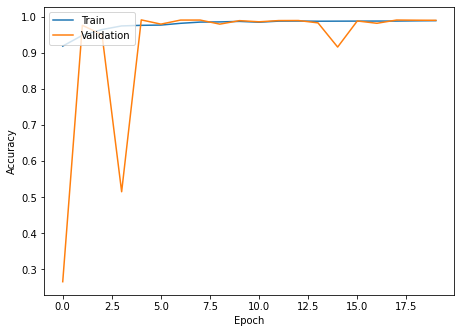

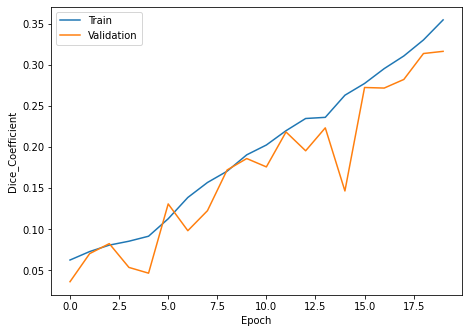

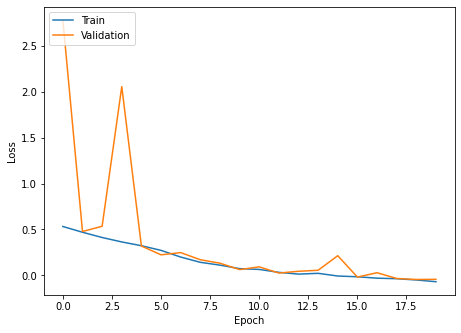

  2%|▏         | 20/1251 [10:37<10:53:40, 31.86s/it]


In [ ]:
import glob
Path= './post_process_data'
p=os.listdir(Path)
Input_Data= []


def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:      
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities

top_limit_number = 1
split_number = 20
init_counter=0
inside_split_countert=1
total_count_img, partial_count_img = len(p), int(len(p)/split_number)

for i in tqdm(p):
    if (int(init_counter*inside_split_countert) == total_count_img) or (int(top_limit_number*split_number)==int(init_counter*inside_split_countert)):
        print("Launch Final model.")
        launch_model(Input_Data,str(init_counter), model)
        del(Input_Data)
        gc.collect()
        break    
    if (init_counter == split_number):
        print("Launch model :"+str(init_counter*inside_split_countert))
        launch_model(Input_Data,str(init_counter*inside_split_countert),model)
        del(Input_Data)
        gc.collect()
        Input_Data= []
        inside_split_countert=inside_split_countert+1
        init_counter=0
    create_path_post=Path+'/'+i+'/*'
    
    for name in sorted(glob.glob(create_path_post.replace('\n',''))):
      os.system('gunzip ' + name)
    brain_dir = os.path.normpath(Path+'/'+i+'/')
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)
    shutil.rmtree(Path+'/'+i)
    init_counter = init_counter + 1
     

**Prediction examples**

In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS2021_{case}_flair.nii.gz');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS2021_{case}_t1ce.nii.gz');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"post_process_data/{case}"
    gt = nib.load(os.path.join(path, f'BraTS2021_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS2021_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [ ]:
#showPredictsById(case=X_test[6][-3:])